# Get geographical data of every German county
Used to map the COVID-19 cases of Germany on a map.<br/>
Gets called from get_data.ipynb (can be run individually).<br/><br/>
Saves the following information reachable through the "AdmUnitID" (Gemeindeschlüssel) in the dictionary "counties_geography":
   - name: Name of the county
   - population: Number of inhabitants from the last official guess, also used in the official incidence calculations
   - geometry: The shape of the county stored in one or more polygons - also determining the position of the county
   - raw_geometry: The original version of the geometry used to draw the surroundings of the counties
   - area_in_m2: Area of the county in square meters, can not be calculated from the polygons stored in geometry
   - (population_density; Added in the file "get_data.ipynb": The area_in_m2 divided by the number of inhabitants times 100.000.)

## Modules
Needed to use non-Python functionalities already programed from someone else.

In [1]:
# Used to convert the json from the API into a python list
from json2xml.utils import readfromurl
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
import json    # to save the data in "json"-format in a file
# USed to check if their is a local file with the data or if a new API pull is inevitable
import os.path

## Control
Set variables to "True" to trigger the action described by the comment and the variables name.<br/><br/>
The variable "no_outputs_from_file_get_shapes_of_german_counties" could get set from the file executing this one.
If it is set to true all variables which create output to monitor the data are set to False and no output is generated.

In [2]:
# decides whether a new pull from the API is made or if a local backup shall be used
counties_geography_new_pull_from_api = True
plot_unmodified_counties_geography_for_rough_overview = False    # takes approximately 2 minutes longer
show_examples_for_functions_for_easier_use_of_the_data = False
max_number_of_counties_to_plot = 4     # highest 102 - more counties need more time
plot_modified_counties_geography_for_rough_overview = True      # takes approximately 2 minutes longer

In [3]:
try:
    no_outputs_from_file_get_shapes_of_german_counties
except NameError:
    no_outputs_from_file_get_shapes_of_german_counties = False


if no_outputs_from_file_get_shapes_of_german_counties:
    plot_unmodified_counties_geography_for_rough_overview = False
    show_examples_for_functions_for_easier_use_of_the_data = False
    max_number_of_counties_to_plot = 0
    plot_modified_counties_geography_for_rough_overview = False

### Control the controls
Check if the necessary files exist otherwise the data must originate from somewhere else. (in this case from the API)

In [4]:
# check if a local pull of the API exists and otherwise initiate a new pull from the API
if not(os.path.isfile("unmodified_data/german_counties_geography.txt")):
    counties_geography_new_pull_from_api = True

## Get the data and safe it in a file
A pull from the [COVID-19 Datenhub provided from the Robert-Koch-Institut](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0?geometry=-30.805%2C46.211%2C52.823%2C55.839) is initiated if "counties_geography_new_pull_from_api" is set to True or if "pulling" from the local backup of an old API-pull is not possible because of missing data. 
<br/>
<br/>
The program raises an error and "pulls" from a local backup of the API if the data does not contain as many counties as requested in the variable "number_of_counties". The variable can be set from the file which calls this one.
If the variable is not defined in the other file or this file is run by itself, the following default-value is used.
<br/>
<br/>
If the unpolished data passes this rudimentary test it is stored as it is in the file "german_counties_geography.txt" in the folder "unmodified_data". If the folder or the file does not yet exist it gets created.<br/>
This file can be used in further executions as local backup of the API-pull.
<br/>
<br/>
If the use of the data from a local backup of the API-pull is requested and possible, the data is provided without further tests.
<br/><br/><br/>
The "number_of_counties" is also set here: It determines how many counties must be present in the data. If there are less or more, the current data-source is declared a fail and (if possible) another one is used. It could also be set from the file calling this one, therefore the try-except-construct.

In [5]:
try:
    number_of_counties
except NameError:
    number_of_counties = 412

In [6]:
# check if new pull from the API is necessary or wished and
# if it is even possible otherwise "pull" from local backup
if counties_geography_new_pull_from_api:
    # get data - the url is kept in this long format to easily copy and check it manually
    counties_geography_raw = readfromurl("https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_Landkreisdaten/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json")
    # data is maybe faulty: if so report to user and use local backup of old API pull
    if len(counties_geography_raw["features"]) != number_of_counties:
        counties_geography_new_pull_from_api = False
        print("The provided data from the API does not have the preset number of counties of" +
        "{}, it has {}.".format(number_of_counties, len(counties_geography_raw["features"])))
    # data seems to be fine: continue
    else:
        # check if the needed directory is availlable - otherwise create it
        if not(os.path.isdir("unmodified_data")): os.makedirs("unmodified_data")
        with open("unmodified_data/german_counties_geography.txt", "w") as file:
            file.write(json.dumps(counties_geography_raw))
        print("Data directly from API is ready to go!")

# Use data from local backup originating from old API pull
# new_pull_from_api could be modified in the if-statement - therefore no else-statement here
if not(counties_geography_new_pull_from_api) and not(counties_geography_use_polished_data):
    with open("unmodified_data/german_counties_geography.txt", "r") as file:
        counties_geography_raw = json.loads(file.read())
    print("Data from old API-pull is ready to go!")

Data directly from API is ready to go!


## Draw the counties
Every countys shape can be reached by calling the value of "geometry" and afterwards "rings". Kept in a very basic way to demonstrate the used data.

In [7]:
if plot_unmodified_counties_geography_for_rough_overview:
    plt.figure(figsize=(20, 20))    # enlarge plot
    # put all shapes into the plot
    for county in counties_geography_raw['features']:
        for polygon in county['geometry']['rings']:
            x,y = np.array(polygon).T
            plt.fill(x, y)
    plt.show()    # draw plot

## Functions for easier use of the data
The following two functions are used multiple times in the following polishing of the data.
### draw_polygon(polygon, plot_immediately, color): returns void (could show a plot)
**polygon**<br/>
-> shape of the polygon/county
<br/>
**plot_immediately** (default: True)<br/>
-> Determines whether "plt.show()" gets executed or not. If not the plot will be drawn with all other plots created in the same manner whenever plt.show() is called - allows to draw multiple polygons in one coordinate system
<br/>
**plt_color** (default: None (standard color sequence))<br/>
-> sets the color of the polygon
### draw_polygons(polygons, plot_single, plot_immediately , plt_color): returns void (could show multiple plots)
**polygons**<br/>
-> shapes of polygons/counties
<br/>
**plot_single** (default: False)<br/>
-> determines wether every polygon shall be drawn in it's on coordinate system or if all polygons shall be accumulated in one
<br/>
**plot_immediately** (default: True)<br/>
-> Determines whether "plt.show()" gets executed in the end or not. If not the plot will be drawn with all other plots created in the same manner whenever plt.show() is called - allows to draw multiple polygons in one coordinate system
<br/>
**plt_color** (default: None (standard color sequence))<br/>
-> sets the color of the polygons

all default: color by standard color scheme and plot immediately


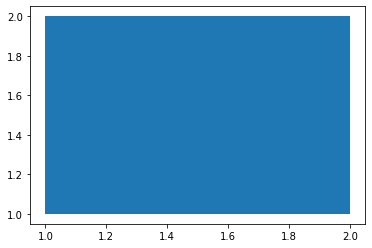

change color to red ('r')


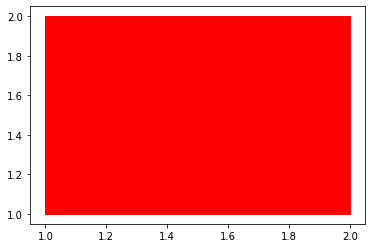

change color to red ('r') and don't draw it
cutout center of the red square from directly above and plot it (color is white)


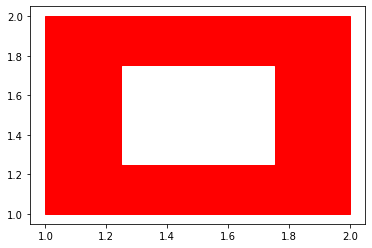

drawing multiple polygons into one plot with the draw_polygons function:


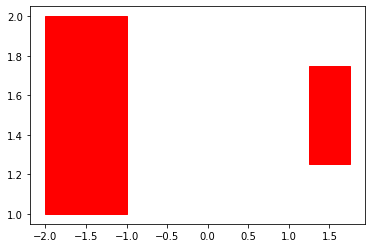

In [8]:
def draw_polygon(polygon, plot_immediately = True, plt_color = None):
    x,y = np.array(polygon).T
    if plt_color:
        plt.fill(x, y, color = plt_color)
    else:
        plt.fill(x, y)
    if plot_immediately: plt.show()


def draw_polygons(polygons, plot_single = False, plot_immediately = True, plt_color = None):
    for polygon in polygons[:-1]:
        draw_polygon(polygon, plot_single, plt_color)
    if len(polygons):
        draw_polygon(polygons[-1], plot_immediately, plt_color)




if show_examples_for_functions_for_easier_use_of_the_data:
    # e.g. to display this rectangle in
    print("all default: color by standard color scheme and plot immediately")
    draw_polygon([[1, 1], [1, 2], [2, 2], [2, 1]])


    print("change color to red ('r')")
    draw_polygon([[1, 1], [1, 2], [2, 2], [2, 1]], True, "r")


    print("change color to red ('r') and don't draw it")
    draw_polygon([[1, 1], [1, 2], [2, 2], [2, 1]], False, "r")
    print("cutout center of the red square from directly above and plot it (color is white)")
    draw_polygon([[1.25, 1.25], [1.25, 1.75], [1.75, 1.75], [1.75, 1.25]], True, "w")

    print("drawing multiple polygons into one plot with the draw_polygons function:")
    draw_polygons([[[-1, 1], [-1, 2], [-2, 2], [-2, 1]],
                   [[1.25, 1.25], [1.25, 1.75], [1.75, 1.75], [1.75, 1.25]]],
                  False, True, "r")

## Create polished version and check the counties with multiple polygons
Every countys shape can be reached by calling the value of "geometry" and afterwards "rings".
<br/>
In the following the needed data gets saved in the variable "counties_geography" and for our purposes useless dictionary-shells get cut away.
<br/>
<br/>
Because the polygons are by far the biggest part of the data we only want to duplicate them if necessary. That is why we only reference them and only copy those we are going to modify.
This a bit risky but more efficient option is chosen because the original data
is backuped as a whole in "unmodified_data/german_counties_geography.txt" as well.
<br/><br/>
Visualization of the reference and copy properties (delete "#"s):

In [9]:
a = [1, 2, 3]
backup_of_a = a
a[1] = 5    # destroys the backup
# print(a, backup_of_a)
a = list()    # sets a new reference
# print(a, backup_of_a)

### Extract necessary data and find all counties with multiple polygons
Save the following information reachable through the "AdmUnitID" (Gemeindeschlüssel) in the dictionary "counties_geography":
   - name: Name of the county
   - population: Number of inhabitants from the last official guess, also used in the official incidence calculations
   - geometry: The shape of the county stored in one or more polygons - also determining the position of the county
   - raw_geometry: The original version of the geometry used to draw the surroundings of the counties
   - area_in_m2: Area of the county in square meters, can not be calculated from the polygons stored in geometry
To execute faster this is done simultaneously to the search for the counties with multiple polygons.
#### Find the counties with enclaves, cutouts, islands or whatsoever
Go through all the counties and if one of them has more than one polygon stored as shape, we store its index in index_of_counties_with_multiple_polygons. Further down they get checked by the user.

In [10]:
counties_geography = dict()
index_of_counties_with_multiple_polygons = list()
for county in counties_geography_raw['features']:
    # convert the AdmUnitId to a string to keep uniformity:
    # after saving and loading from a file all keys are strings
    AdmUnitId = str(county['attributes']['AdmUnitId'])
    counties_geography[AdmUnitId] = dict(
        name = county['attributes']['county'],
        population = county['attributes']['EWZ'],
        area_in_m2 = county['attributes']['Shape__Area'],
        # referencing the original polygons -
        # cf. "Visualization of the reference and copy properties" further above
        geometry = county['geometry']['rings'],
        raw_geometry = county['geometry']['rings']
    )
    # store the index of every county with more than one polygon
    if len(county['geometry']['rings']) > 1:
        index_of_counties_with_multiple_polygons.append(AdmUnitId)

### Check the counties with multiple polygons - helper functions
If a county has more than one polygon stored as shape, it must be checked whether its polygons are cutouts or real area.
The fastest way is to do this by hand, so there are three functions to support that:<br/>

### draw_polygons(polygons, plot_single, plot_immediately , plt_color): returns void (could show multiple plots)
**polygons**<br/>
-> shapes of polygons/counties
<br/>



### draw_polygons_of_county(AdmUnitId): returns void (could show polygons of given county)
**AdmUnitId**<br/>
-> identifier of the county whichs polygon(s) shall be drawn
### set_polygons_of_county(AdmUnitId, areas_or_cutouts_list): returns void (could show polygons of given county) 
Processes the decision of the user and could plot the polygons of the given county to double check the decisions.<br/>
**AdmUnitId**<br/>
-> identifier of the county whichs polygon(s) shall be modified and drawn
**areas_or_cutouts_list** - same length as list of polygons related to this county, allows "add", "remove" or "exclude" as elements.<br/>
-> Determines which of the following actions shall be taken:<br/>
Executes the following for every polygon related to the county, determined by the keywords (highlighted with "") in the 
- just "add" the polygon to the dictionary stored in counties_geography[AdmUnitID]['geometry']['rings'],
- "remove"/cut the polygon out of it's predecessor in the polygon list counties_geography[AdmUnitID]['geometry']['rings']
  (this is done by adding it to the prior polygon and adding the last coordinate again,
  so technicaly there's a small slice cut out of the real area, but this is no problem for our purposes)
- or simply "exclude" the polygon.

### generator_index_of_counties_with_multiple_polygons(): returns a generator to iterate over the collection of counties with multiple polygons

In [11]:
def draw_polygons_of_county(AdmUnitId):
    # max_number_of_counties_to_plot gets set at the begining of the file to execute faster
    global max_number_of_counties_to_plot
    if max_number_of_counties_to_plot >= 0:
        county = counties_geography[AdmUnitId]
        plt.rcParams["figure.figsize"]= (20, 20)    # enlarge plot
        # title of the plot
        plt.title("{} {} with {} polygons".format(AdmUnitId, county['name'], len(county['geometry'])))
        draw_polygons(county['geometry'])

In [12]:
def set_polygons_of_county(AdmUnitId, areas_or_cutouts_list):
    county = counties_geography[AdmUnitId]

    # check if every polygon gets a value
    if len(county['geometry']) != len(areas_or_cutouts_list):
        raise Exception("lists of areas and cutouts and the polygon list" +
                        "do not have the same length: {} =/= {}".format(
        len(areas_or_cutouts_list), len(county['geometry'])))

    # create list to not destroy the backup
    # (explained in "Visualization of the reference and copy properties")
    new_county_geometry = list()

    # process user information:
    # - "exclude" to discard polygon
    # - "add" to leave as is (for enclaves)
    # - "remove" to trade as cutout: add it to the prior polygon (not possible for first polygon)
    for polygon_index in range(len(county['geometry'])):
        if areas_or_cutouts_list[polygon_index] == "add":
            new_county_geometry.append(county['geometry'][polygon_index].copy())
        elif areas_or_cutouts_list[polygon_index] == "remove":
            if polygon_index == 0:
                raise Exception("The first polygon can't be cutout of it's prior polygon" +
                                "because there's no prior polygon")
            new_county_geometry[-1] += county['geometry'][polygon_index].copy() + [new_county_geometry[-1][-1]]
        # nothing needs to be done if the command is "exclude", but if the command is unknown an error shall be raised
        elif not(areas_or_cutouts_list[polygon_index] == "exclude"):
            raise Exception("The command {} is not known - use 'add', 'remove' or" +
                            "'exclude'".format(areas_or_cutouts_list[polygon_index]))

    county['geometry'] = new_county_geometry

    # draw to control
    draw_polygons_of_county(AdmUnitId)

In [13]:
def generator_index_of_counties_with_multiple_polygons():
    for index_of_county_with_multiple_polygons in index_of_counties_with_multiple_polygons:
        global max_number_of_counties_to_plot
        max_number_of_counties_to_plot -= 1
        yield index_of_county_with_multiple_polygons
unchecked_counties = generator_index_of_counties_with_multiple_polygons()

### Check the counties with multiple polygons
The user has to go through all the counties and determine whether in the "areas_or_cutouts_list" the area shall be treated as area ("add") or cutout ("remove"), for irrelevant polygons "exclude" can be choosen.

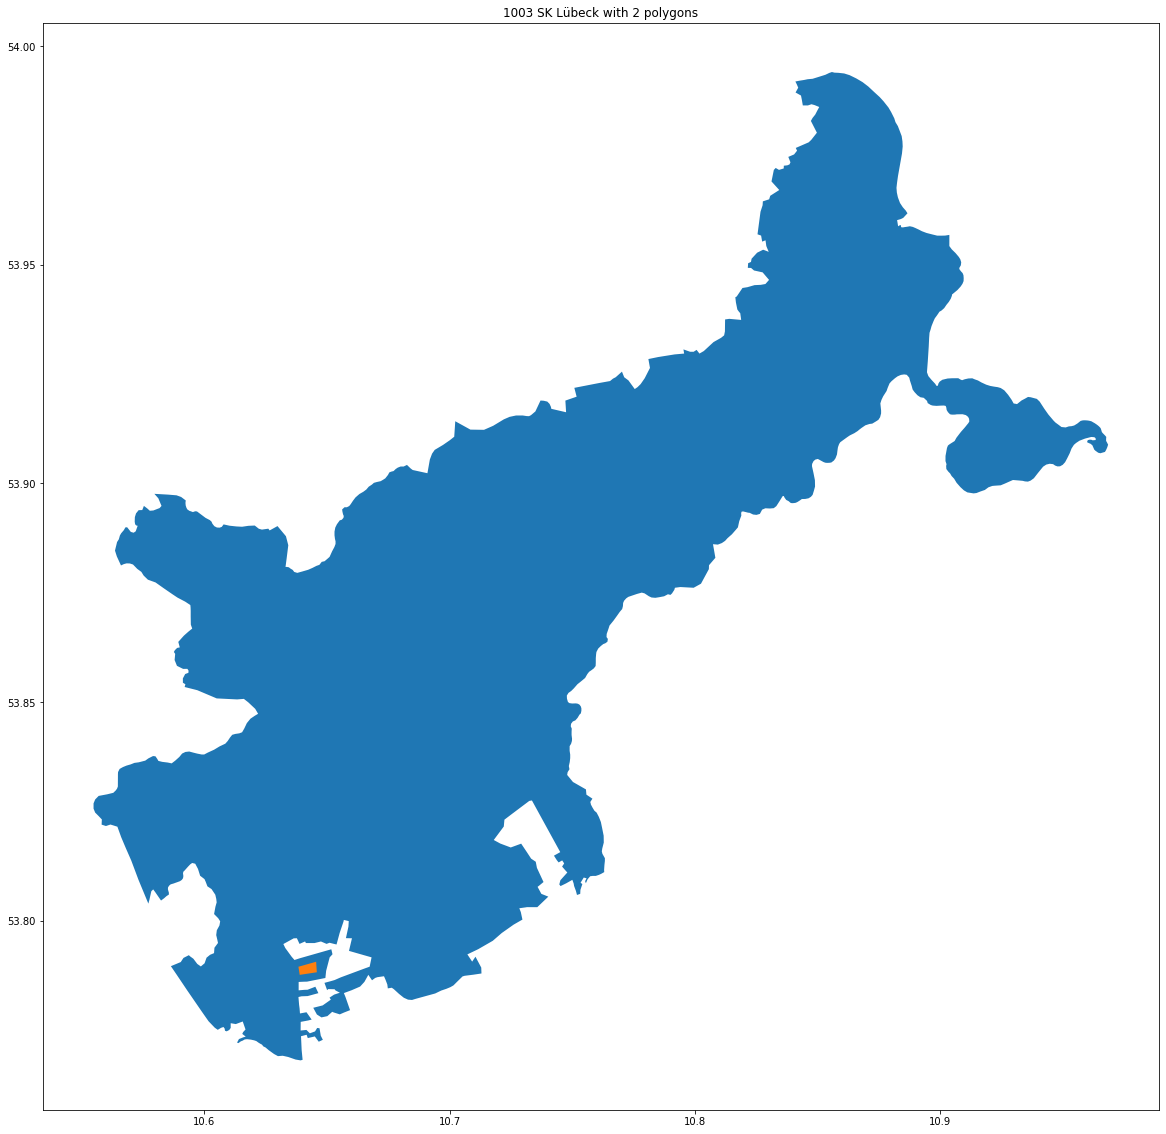

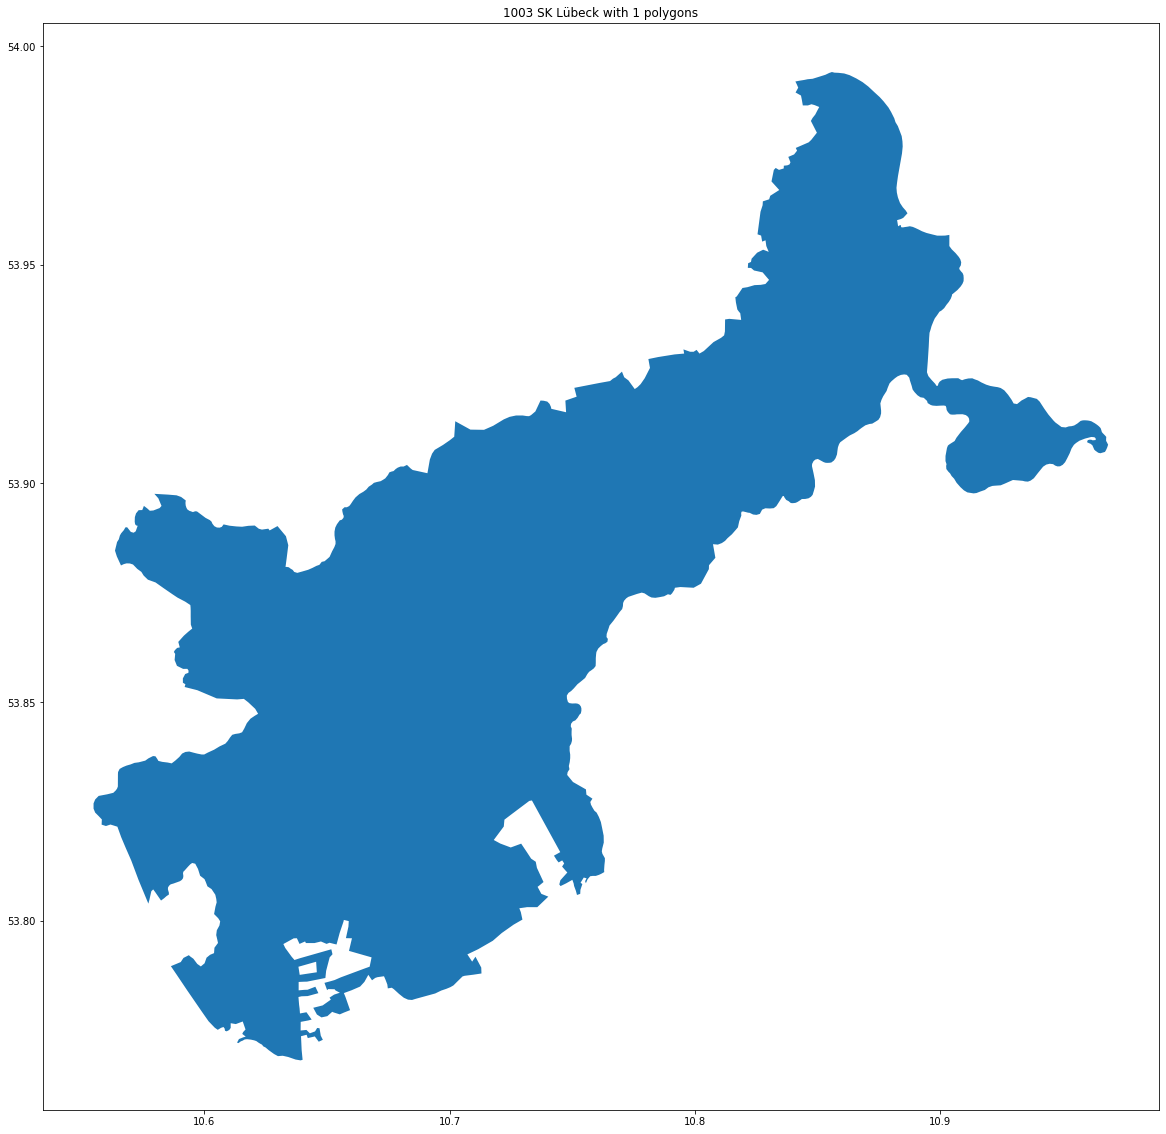

In [14]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

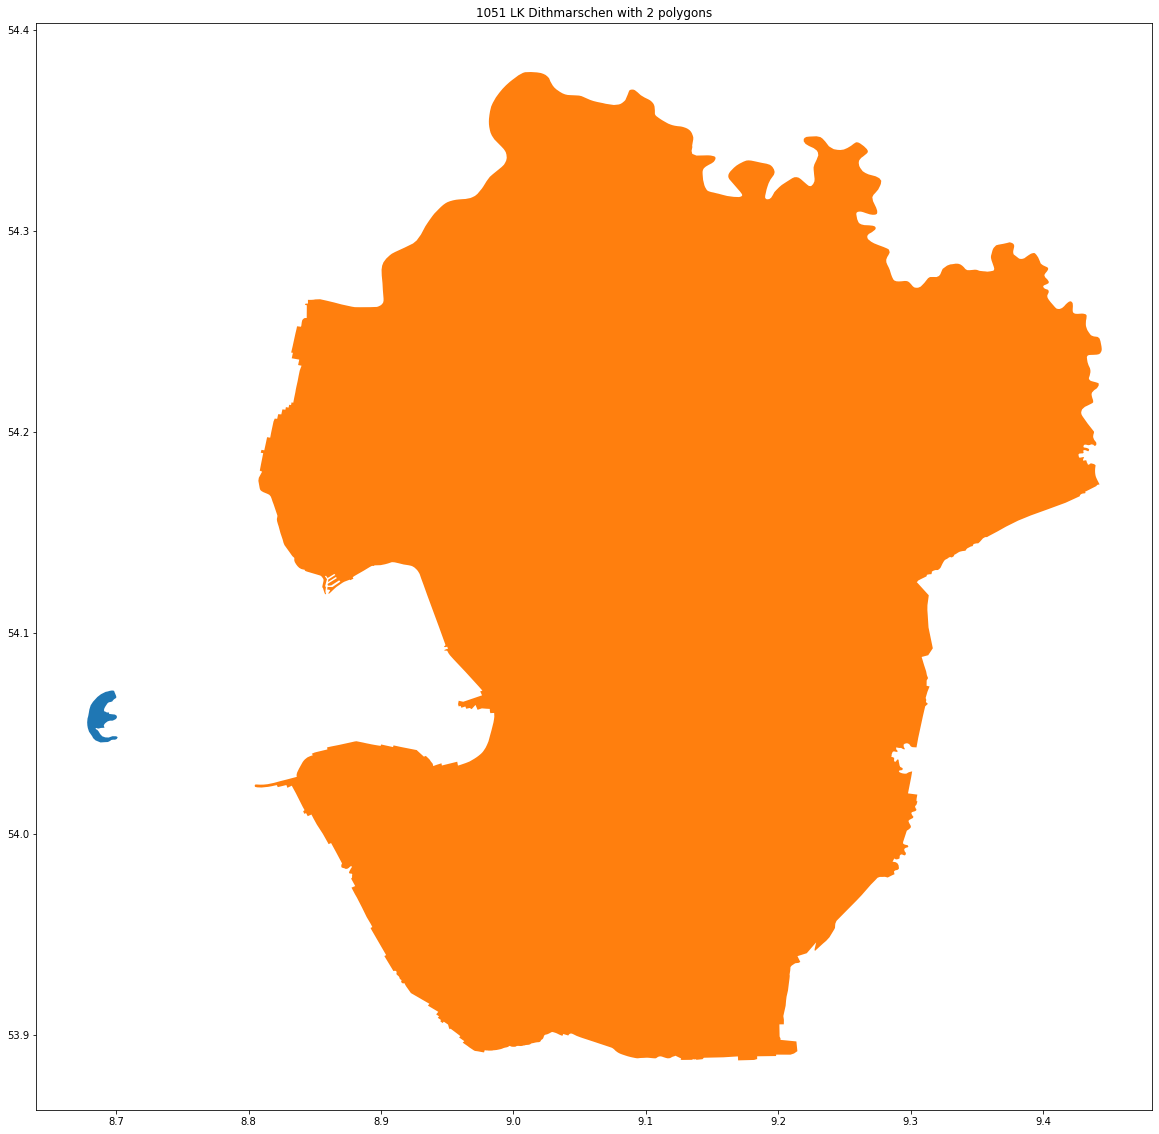

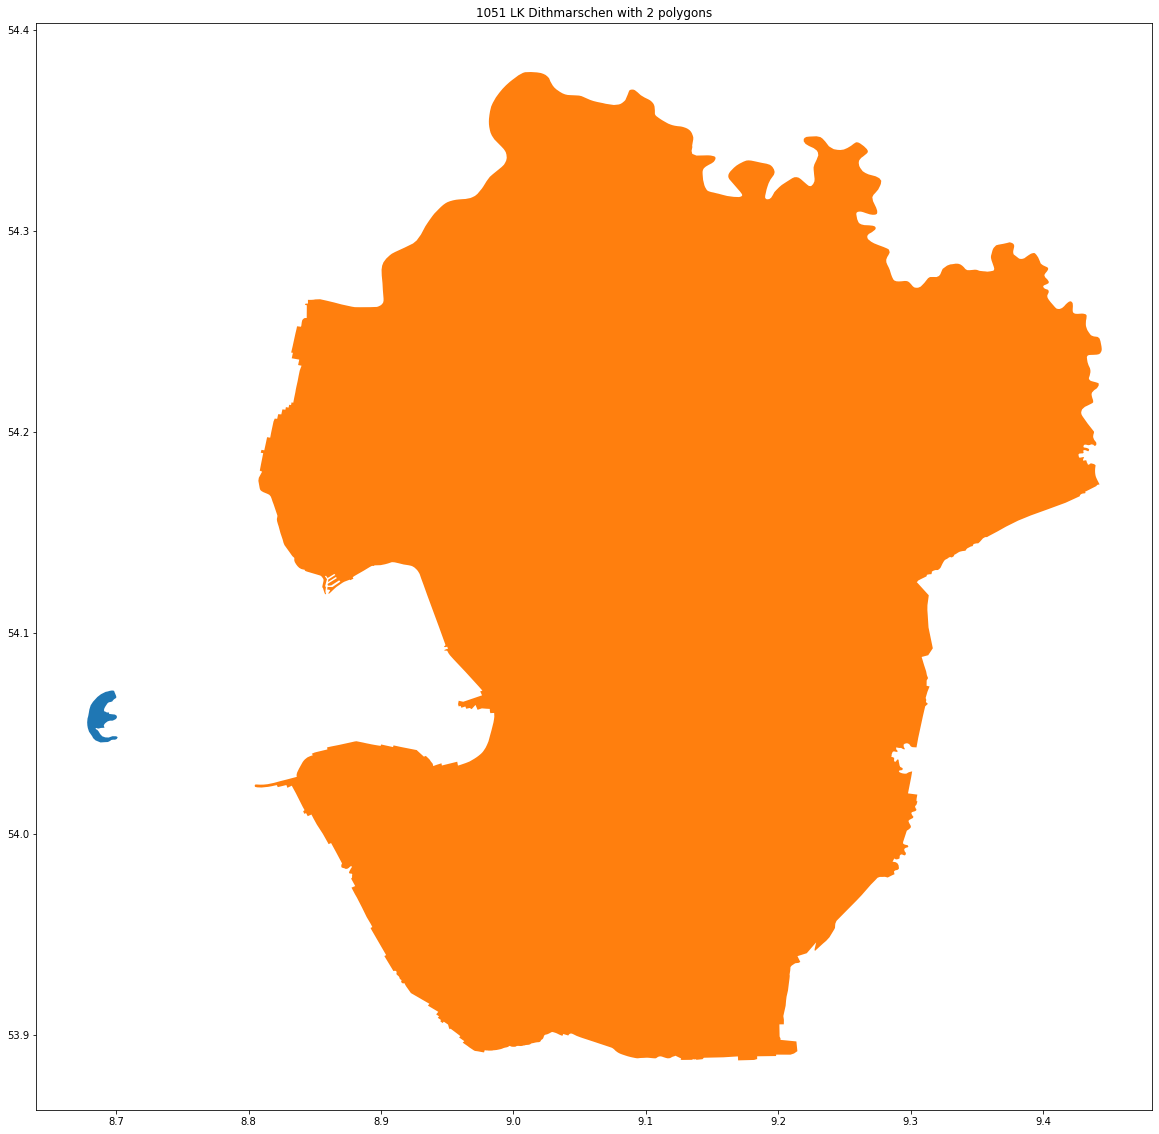

In [15]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

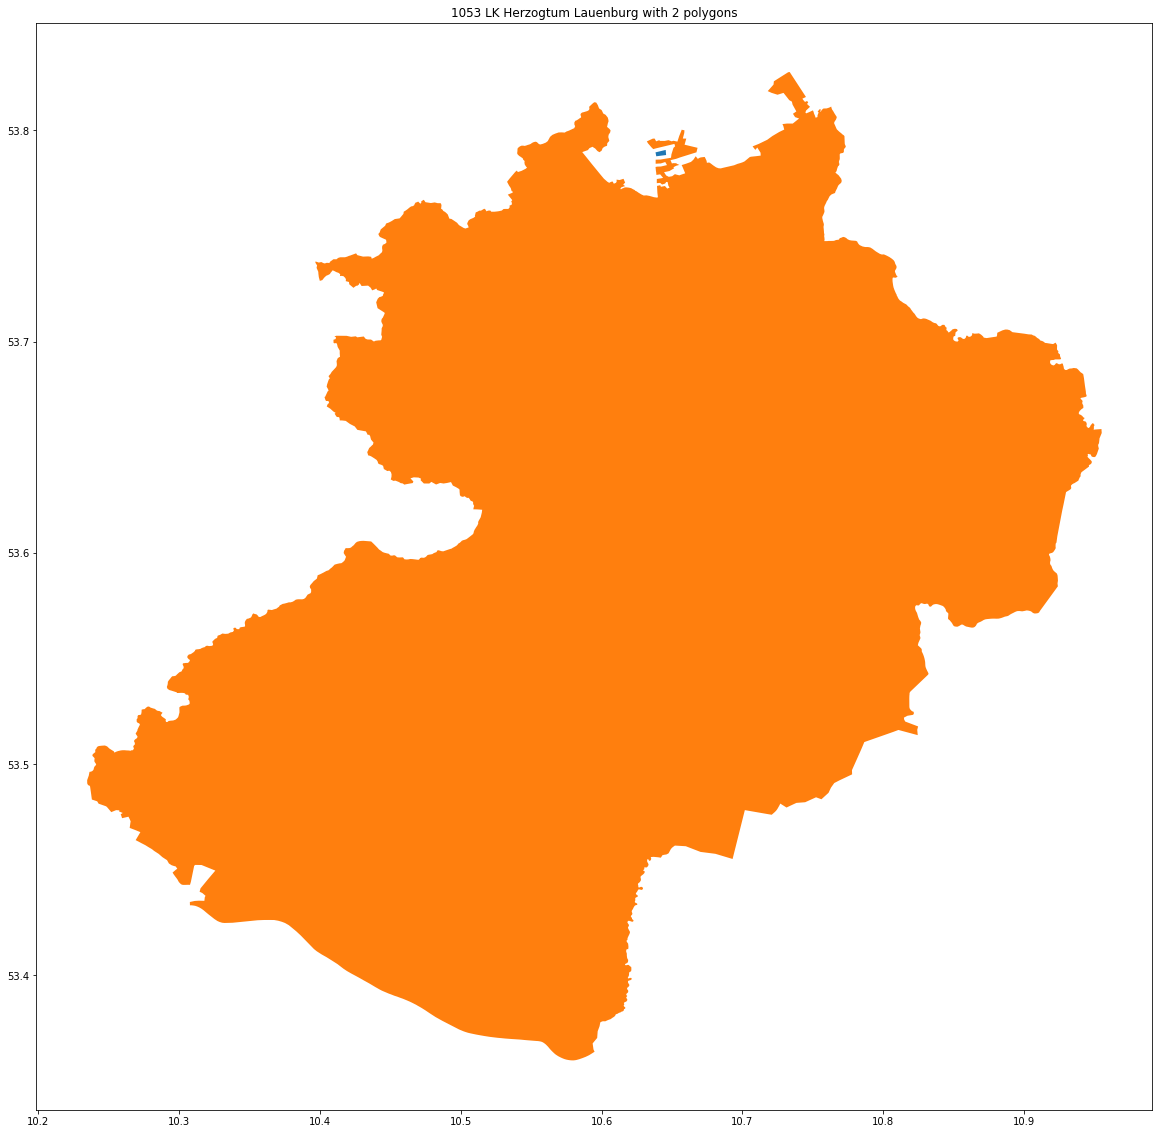

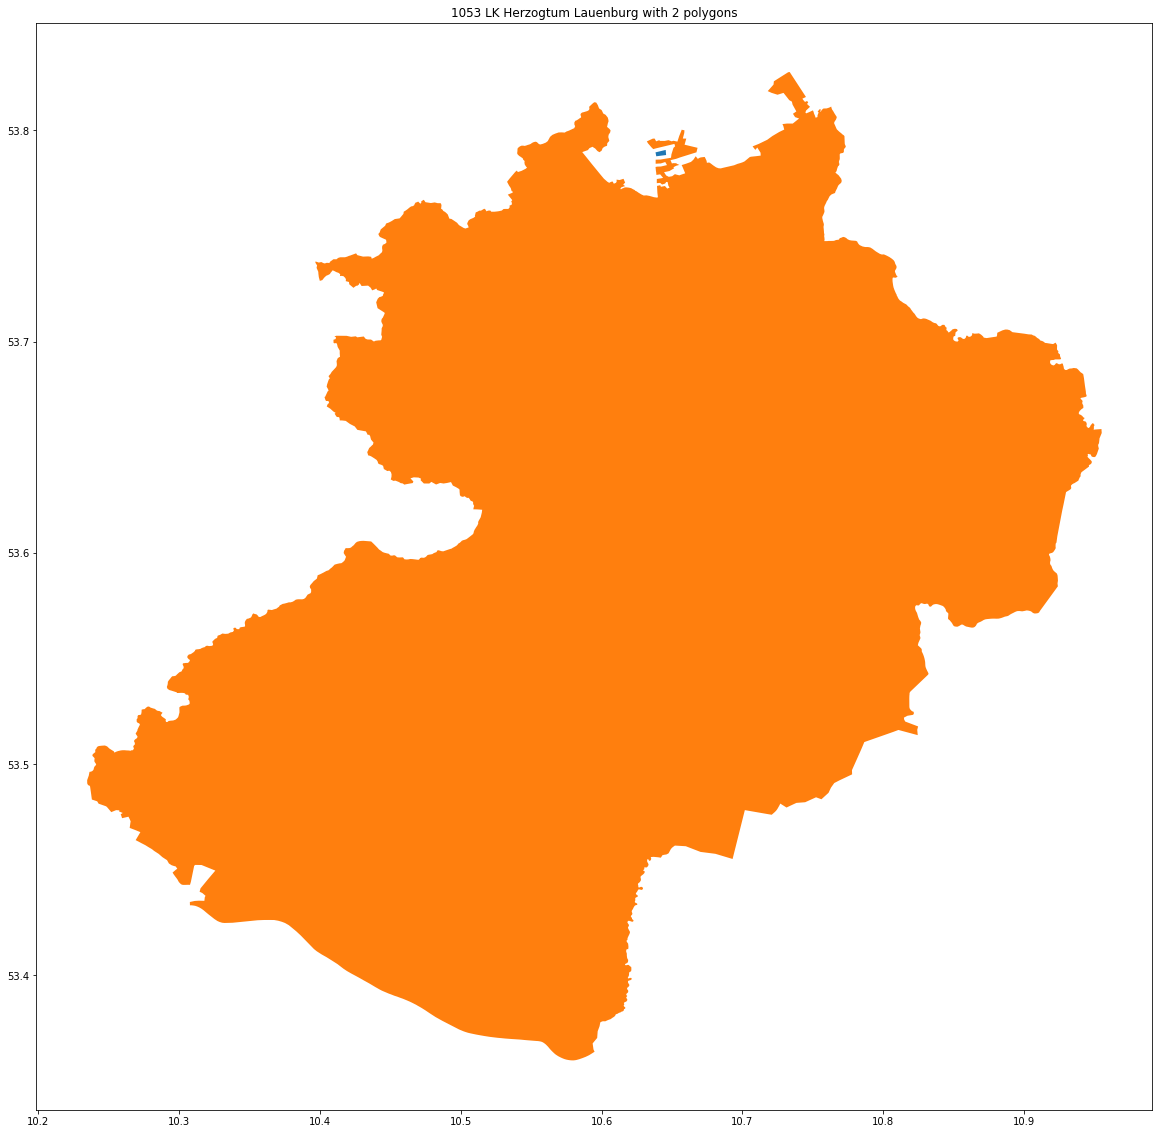

In [16]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

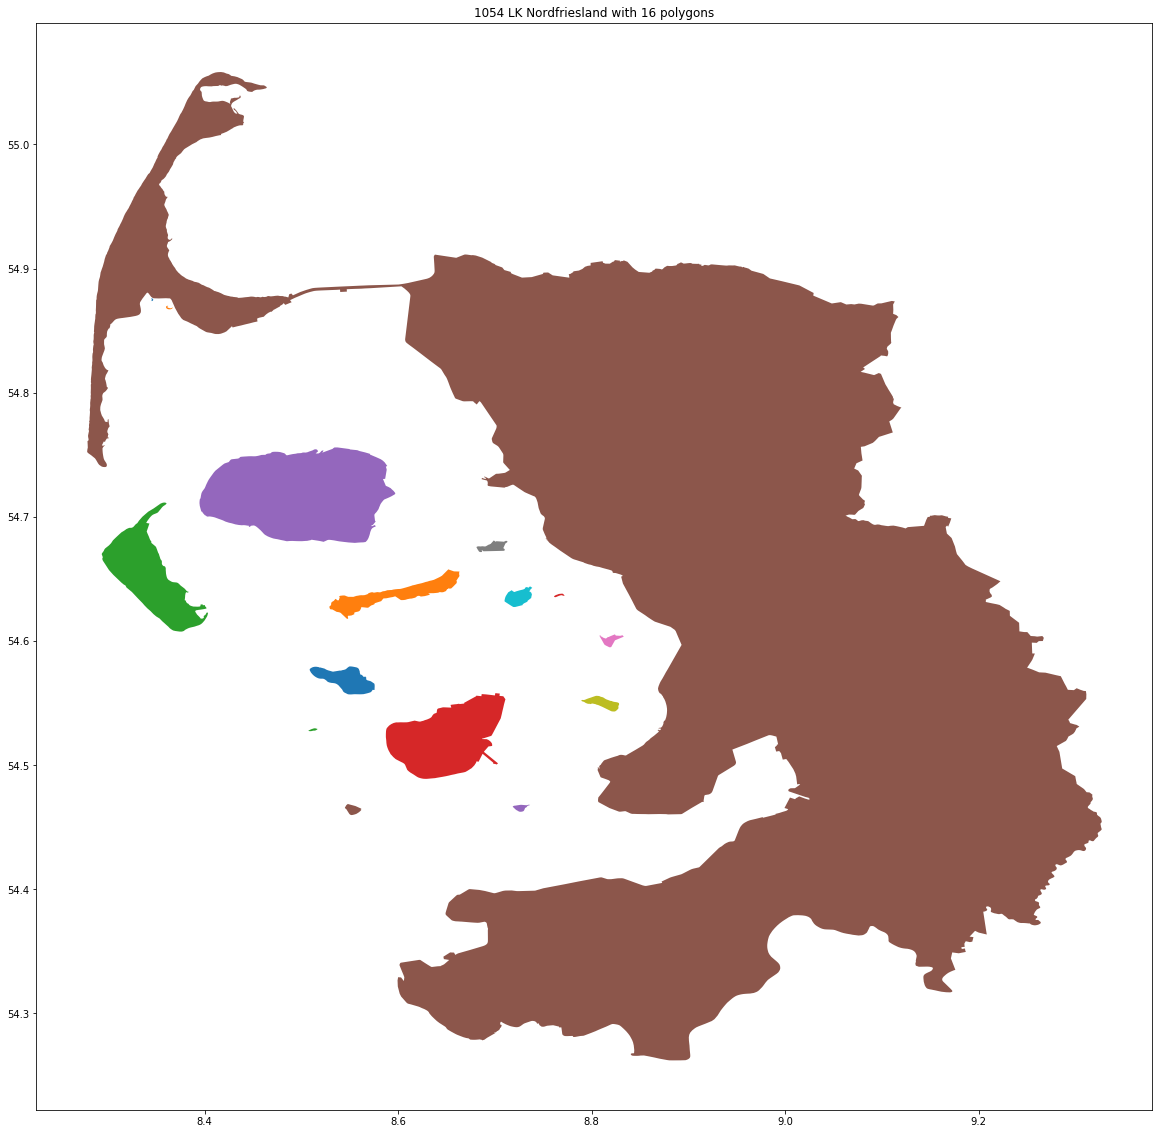

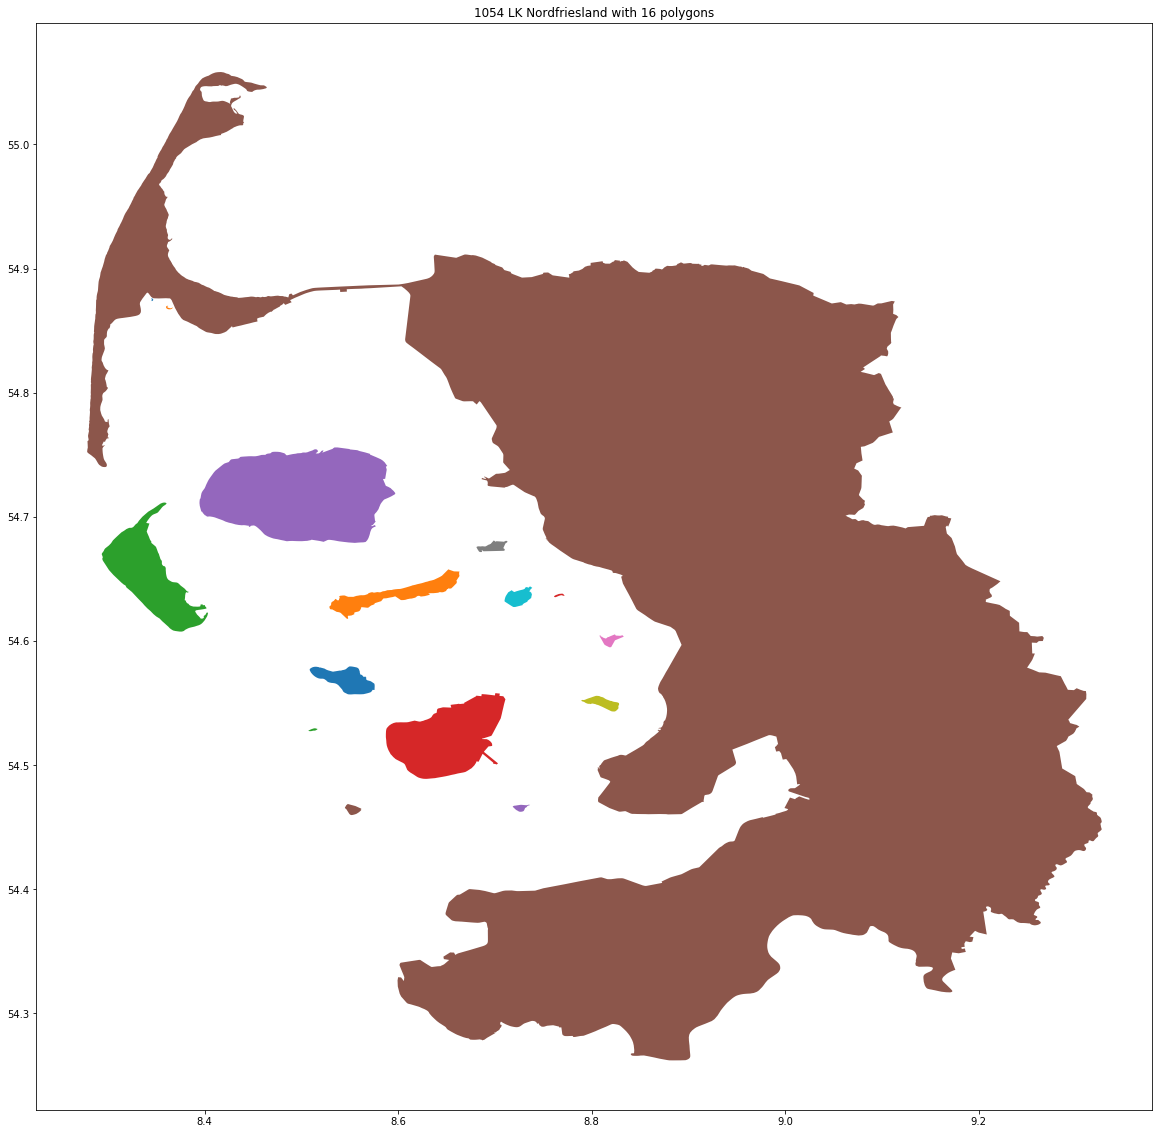

In [17]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add", "add", "add", "add", "add", "add", "add", "add", "add", "add", "add", "add"])

In [18]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [19]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add", "add", "add", "add"])

In [20]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [21]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [22]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [23]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [24]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add"])

In [25]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [26]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [27]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [28]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [29]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [30]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [31]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add", "add", "add"])

In [32]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [33]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add"])

In [34]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [35]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [36]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [37]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [38]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [39]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [40]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [41]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add"])

In [42]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "add", "add"])

In [43]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [44]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [45]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [46]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [47]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [48]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [49]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [50]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [51]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [52]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [53]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [54]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [55]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [56]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [57]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [58]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "remove", "remove", "remove"])

In [59]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [60]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "remove", "remove", "remove", "remove", "remove", "remove", "remove"])

In [61]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [62]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [63]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add"])

In [64]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [65]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [66]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "remove"])

In [67]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove", "remove"])

In [68]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [69]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [70]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [71]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [72]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [73]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [74]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [75]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [76]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove", "remove"])

In [77]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [78]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [79]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [80]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [81]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [82]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [83]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [84]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [85]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [86]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [87]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [88]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [89]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [90]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [91]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [92]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [93]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [94]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [95]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [96]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [97]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [98]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [99]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [100]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add"]*37)

In [101]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "add", "add", "remove", "remove"])

In [102]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add"]*21)

In [103]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add"])

In [104]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [105]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [106]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [107]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove", "remove"])

In [108]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "remove"])

In [109]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove", "remove"])

In [110]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "remove"])

In [111]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [112]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add"])

In [113]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [114]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "remove"])

In [115]:
current_county_index = next(unchecked_counties)
draw_polygons_of_county(current_county_index)
set_polygons_of_county(current_county_index, ["add", "add", "add", "add", "remove"])

## Save the modified data in file
The polished data gets saved in the file "german_counties_geography.txt" in the folder "modified_data" inside the current directory. If the directory does not exist it gets created.

In [116]:
if not(os.path.isdir("modified_data")): os.makedirs("modified_data")
with open("modified_data/german_counties_geography.txt", "w") as file:
    file.write(json.dumps(counties_geography))

## Draw the counties
Every countys shape can be reached by calling the value of "geometry" and afterwards "rings". Kept in a very basic way to demonstrate the used data.

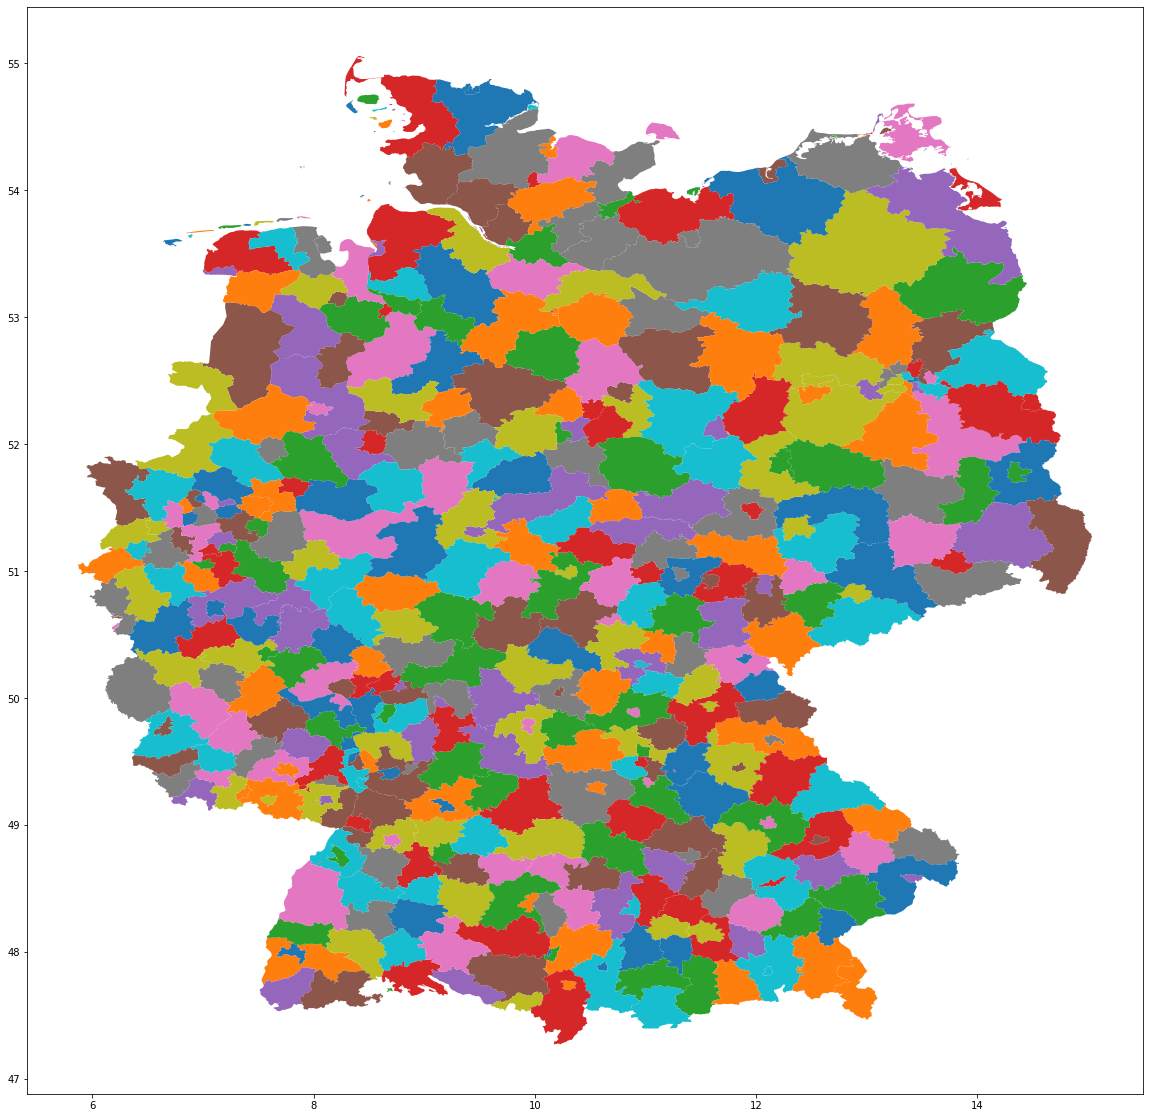

In [117]:
if plot_modified_counties_geography_for_rough_overview:
    plt.figure(figsize = (20, 20))    # enlarge plot
    for county in counties_geography.values():
        for polygon in county['geometry']:
            x,y = np.array(polygon).T
            plt.fill(x, y)
    plt.show()